In [9]:
#this notebook was taken from  https://github.com/qubvel/segmentation_models/blob/master/examples/multiclass%20segmentation%20(camvid).ipynb
!pip3 install -U albumentations>=0.3.0 --user 
!pip3 install -U --pre segmentation-models --user
!pip3 install keras==2.3.1
!pip3 install tensorflow==2.1.0
!pip3 install keras_applications==1.0.8
!pip3 install image-classifiers==1.0.0
!pip3 install efficientnet==1.0.0

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
     |################################| 377 kB 2.6 MB/s eta 0:00:01
     |################################| 42 kB 60 kB/s s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
     |################################| 421.8 MB 4.2 kB/s  eta 0:00:01  |                                | 3.7 MB 3.3 MB/s eta 0:02:07
     |################################| 26.1 MB 4.0 kB/s  eta 0:00:01
     |################################| 129 kB 70.5 MB/s eta 0:00:01
     |################################| 57 kB 187 kB/s  eta 0:00:01
     |################################| 4.1 MB 59.0 MB/s eta 0:00:01
     |######

In [12]:
 !pip3 install -U git+https://github.com/albu/albumentations --no-cache-dir

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-bq_v_pqp
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [13]:
import segmentation_models as sm
import albumentations as A

In [4]:
import os
import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [5]:
DATA_DIR = './data/'

Loading data...
Done!


In [6]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

In [7]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
               'tree', 'signsymbol', 'fence', 'car', 
               'pedestrian', 'bicyclist', 'unlabelled']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [8]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=240, min_width=360, always_apply=True, border_mode=0),
        A.RandomCrop(height=240, width=360, always_apply=True),

        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(384, 480)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

In [20]:
BACKBONE = 'efficientnetb3'
BATCH_SIZE = 8
CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
               'tree', 'signsymbol', 'fence', 'car', 
               'pedestrian', 'bicyclist', 'unlabelled']
LR = 0.0001
EPOCHS = 40

preprocess_input = sm.get_preprocessing(BACKBONE)

# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

In [21]:


# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([1, 1,1,1,1,1,1,1,1,1,1,1, 0.5])) 
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [22]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

print(train_dataloader[0][0].shape)
# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 320, 320, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 320, 320, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model_2.h5', save_weights_only=False, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

(8, 320, 320, 3)


In [23]:
# train model
with tf.device('/device:GPU:0'):

    history = model.fit_generator(
        train_dataloader, 
        steps_per_epoch=len(train_dataloader), 
        epochs=EPOCHS, 
        callbacks=callbacks, 
        validation_data=valid_dataloader, 
        validation_steps=len(valid_dataloader),
    )

Epoch 1/40
45/45 [==============================] - 89s 2s/step - loss: 0.9446 - iou_score: 0.0833 - f1-score: 0.0971 - val_loss: 0.9241 - val_iou_score: 0.1437 - val_f1-score: 0.1618
Epoch 2/40
45/45 [==============================] - 32s 704ms/step - loss: 0.8502 - iou_score: 0.2278 - f1-score: 0.2574 - val_loss: 0.8360 - val_iou_score: 0.2693 - val_f1-score: 0.2978
Epoch 3/40
45/45 [==============================] - 34s 767ms/step - loss: 0.7906 - iou_score: 0.2931 - f1-score: 0.3242 - val_loss: 0.7937 - val_iou_score: 0.3156 - val_f1-score: 0.3385
Epoch 4/40
45/45 [==============================] - 34s 765ms/step - loss: 0.7585 - iou_score: 0.3128 - f1-score: 0.3428 - val_loss: 0.7651 - val_iou_score: 0.3207 - val_f1-score: 0.3434
Epoch 5/40
45/45 [==============================] - 38s 836ms/step - loss: 0.7253 - iou_score: 0.3329 - f1-score: 0.3677 - val_loss: 0.7125 - val_iou_score: 0.3724 - val_f1-score: 0.4034
Epoch 6/40
45/45 [==============================] - 32s 722ms/step -

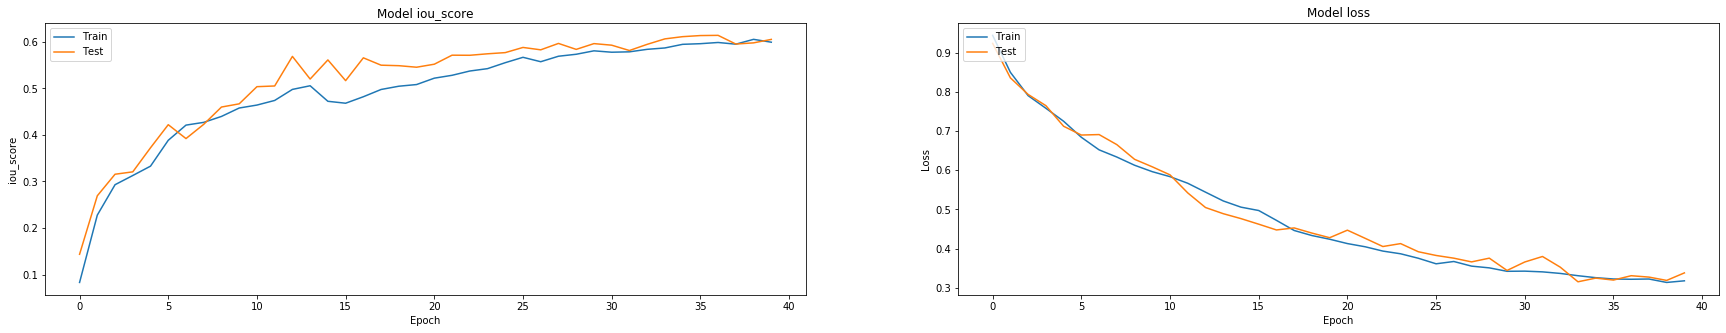

<Figure size 432x288 with 0 Axes>

In [116]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.savefig('test.png', bbox_inches='tight')

In [29]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

In [26]:
model.load_weights('model.h5')

In [27]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.61341
mean iou_score: 0.52472
mean f1-score: 0.60434
